# DSGE Smets & Wouters - Argentina: Figuras 1 y 2

Este notebook genera las Figuras 1 y 2 del modelo Smets & Wouters (2007) aplicado a datos de Argentina.

**Figura 1**: Forecast Error Variance Decomposition (FEVD)
- Descomposicion de varianza del error de pronostico para GDP growth, Inflation y Interest rate
- Muestra la contribucion de cada shock estructural a diferentes horizontes

**Figura 2**: Impulse Response Functions (IRFs) a shocks de demanda
- Respuestas de Output, Hours, Inflation e Interest Rate a shocks de demanda
- Shocks: Risk premium, Government spending, Investment

**Requisitos previos**:
- Ejecutar primero `tables_argentina.ipynb` para generar `argmodel_mode.mat`
- GNU Octave y Dynare instalados

## 1. Setup y Configuracion

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

# Agregar directorio padre al path
sys.path.append(str(Path.cwd().parent))

from src import DynareInterface

# Configurar graficos
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Imports completados")

Imports completados


In [2]:
# Configurar rutas - MODIFICAR SEGUN TU INSTALACION
os.environ['OCTAVE_EXECUTABLE'] = r'C:\Program Files\GNU Octave\Octave-10.3.0\mingw64\bin\octave-cli.exe'

DYNARE_PATH = r'C:\dynare\6.5\matlab'
MODEL_PATH = Path.cwd().parent / 'model'
OUTPUT_PATH = Path.cwd().parent / 'output'

print(f"Octave executable: {os.environ['OCTAVE_EXECUTABLE']}")
print(f"Dynare path: {DYNARE_PATH}")
print(f"Model path: {MODEL_PATH}")
print(f"Model exists: {MODEL_PATH.exists()}")

Octave executable: C:\Program Files\GNU Octave\Octave-10.3.0\mingw64\bin\octave-cli.exe
Dynare path: C:\dynare\6.5\matlab
Model path: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\DG\model
Model exists: True


## 2. Definiciones para Figuras

In [3]:
# Labels para los 7 shocks estructurales
SHOCK_LABELS = {
    'ea': 'Productividad',
    'eb': 'Prima de riesgo',
    'eg': 'Gasto gobierno',
    'eqs': 'Inversion',
    'em': 'Pol. monetaria',
    'epinf': 'Markup precios',
    'ew': 'Markup salarios'
}

SHOCK_ORDER = ['ea', 'eb', 'eg', 'eqs', 'em', 'epinf', 'ew']

# Figura 1: Variables para FEVD
FIGURE1_VARIABLES = ['dy', 'pinfobs', 'robs']
FIGURE1_LABELS = {
    'dy': 'Crecimiento PIB',
    'pinfobs': 'Inflacion',
    'robs': 'Tasa de Interes'
}

# Figura 2: IRFs a shocks de demanda
DEMAND_SHOCKS = ['eb', 'eg', 'eqs']
FIGURE2_VARIABLES = ['y', 'lab', 'pinfobs', 'robs']
FIGURE2_LABELS = {
    'y': 'Output',
    'lab': 'Horas',
    'pinfobs': 'Inflacion',
    'robs': 'Tasa de Interes'
}

print("Configuracion definida")
print(f"\nFigura 1 - FEVD para: {FIGURE1_VARIABLES}")
print(f"Figura 2 - IRFs de {FIGURE2_VARIABLES} a shocks: {DEMAND_SHOCKS}")

Configuracion definida

Figura 1 - FEVD para: ['dy', 'pinfobs', 'robs']
Figura 2 - IRFs de ['y', 'lab', 'pinfobs', 'robs'] a shocks: ['eb', 'eg', 'eqs']


## 3. Ejecutar Dynare

In [4]:
# Inicializar interfaz Dynare
di = DynareInterface(DYNARE_PATH, str(MODEL_PATH))
print("Interfaz Dynare inicializada")

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

Interfaz Dynare inicializada


In [5]:
# Ejecutar modelo de figuras
print("Ejecutando argmodel_figures.mod...")
print("(Esto puede tardar varios minutos)\n")

di.run_model('argmodel_figures.mod')

print("\nDynare completado")

Ejecutando argmodel_figures.mod...
(Esto puede tardar varios minutos)


Step 1: Closing Octave session to release file locks...
Waiting for Windows to release file handles...

Step 2: Cleaning up directories...
Searching for directories to clean up...
No directories found to clean up.

Step 3: Starting fresh Octave session...
    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

Octave session ready

Step 4: Running Dynare estimation...
Command: dynare argmodel_figures nograph
(This may take several minutes...)

Starting Dynare (version 6.5).
Calling Dynare with arguments: nograph
Starting preprocessing of the model file ...
Found 40 equation(s).
Evaluating expressions...
Computing static model derivatives (order 1).
Normalizing the static model...
Finding the optimal block decomposition of the static model...
11 block(s) found:
  9 recursive block(s) and 2 simultaneous block(s).
  the largest simultaneous block has 13 equation(s)
       

## 4. Extraer FEVD para Figura 1

In [6]:
def extract_fevd(di, max_horizon=40):
    """
    Extrae la Conditional Variance Decomposition de Dynare 6.x.
    
    Returns:
        DataFrame con columnas: horizon, variable, shock, variance_share (en %)
    """
    has_fevd = di.oc.eval('isfield(oo_, "conditional_variance_decomposition")', nout=1)
    if not has_fevd:
        raise RuntimeError("FEVD no encontrada.")
    
    fevd_size = di.oc.eval('size(oo_.conditional_variance_decomposition)', nout=1)
    fevd_size = np.array(fevd_size).flatten()
    
    n_vars = int(fevd_size[0])
    n_horizons = int(fevd_size[1])
    n_shocks = int(fevd_size[2])
    
    print(f"FEVD: {n_vars} variables x {n_horizons} horizontes x {n_shocks} shocks")
    
    stoch_vars = ['dy', 'pinfobs', 'robs', 'y', 'lab', 'labobs']
    var_names = stoch_vars[:n_vars]
    shock_names = ['ea', 'eb', 'eg', 'eqs', 'em', 'epinf', 'ew']
    
    fevd_array = di.oc.eval('oo_.conditional_variance_decomposition', nout=1)
    
    data = []
    for h in range(min(n_horizons, max_horizon)):
        for v in range(n_vars):
            for s in range(n_shocks):
                value = fevd_array[v, h, s] * 100
                data.append({
                    'horizon': h + 1,
                    'variable': var_names[v],
                    'shock': shock_names[s],
                    'variance_share': float(value)
                })
    
    return pd.DataFrame(data)

print("Extrayendo FEVD...\n")
fevd_df = extract_fevd(di, max_horizon=40)

print(f"\nFEVD extraida: {len(fevd_df)} filas")

# Verificacion
print("\nVerificacion (suma debe ser ~100%):")
for var in ['dy', 'pinfobs', 'robs']:
    for h in [1, 10, 40]:
        total = fevd_df[(fevd_df['variable']==var) & (fevd_df['horizon']==h)]['variance_share'].sum()
        print(f"  {var} h={h}: {total:.1f}%")

Extrayendo FEVD...

FEVD: 6 variables x 100 horizontes x 7 shocks

FEVD extraida: 1680 filas

Verificacion (suma debe ser ~100%):
  dy h=1: 100.0%
  dy h=10: 100.0%
  dy h=40: 100.0%
  pinfobs h=1: 100.0%
  pinfobs h=10: 100.0%
  pinfobs h=40: 100.0%
  robs h=1: 100.0%
  robs h=10: 100.0%
  robs h=40: 100.0%


## 5. Extraer IRFs para Figura 2

In [7]:
# Extraer IRFs
print("Extrayendo IRFs...\n")

irfs_df = di.get_irfs(periods=20)

print(f"IRFs extraidas: {len(irfs_df)} observaciones")
print(f"\nVariables: {irfs_df['variable'].unique()}")
print(f"Shocks: {irfs_df['shock'].unique()}")

# Filtrar para Figura 2
figure2_irfs = irfs_df[
    (irfs_df['variable'].isin(FIGURE2_VARIABLES)) & 
    (irfs_df['shock'].isin(DEMAND_SHOCKS))
].copy()

print(f"\nIRFs para Figura 2: {len(figure2_irfs)} observaciones")

Extrayendo IRFs...

IRFs extraidas: 840 observaciones

Variables: ['dy' 'pinfobs' 'robs' 'y' 'lab' 'labobs']
Shocks: ['ea' 'eb' 'eg' 'eqs' 'em' 'epinf' 'ew']

IRFs para Figura 2: 240 observaciones


## 6. Graficar Figura 1: FEVD

Generando Figura 1: FEVD...



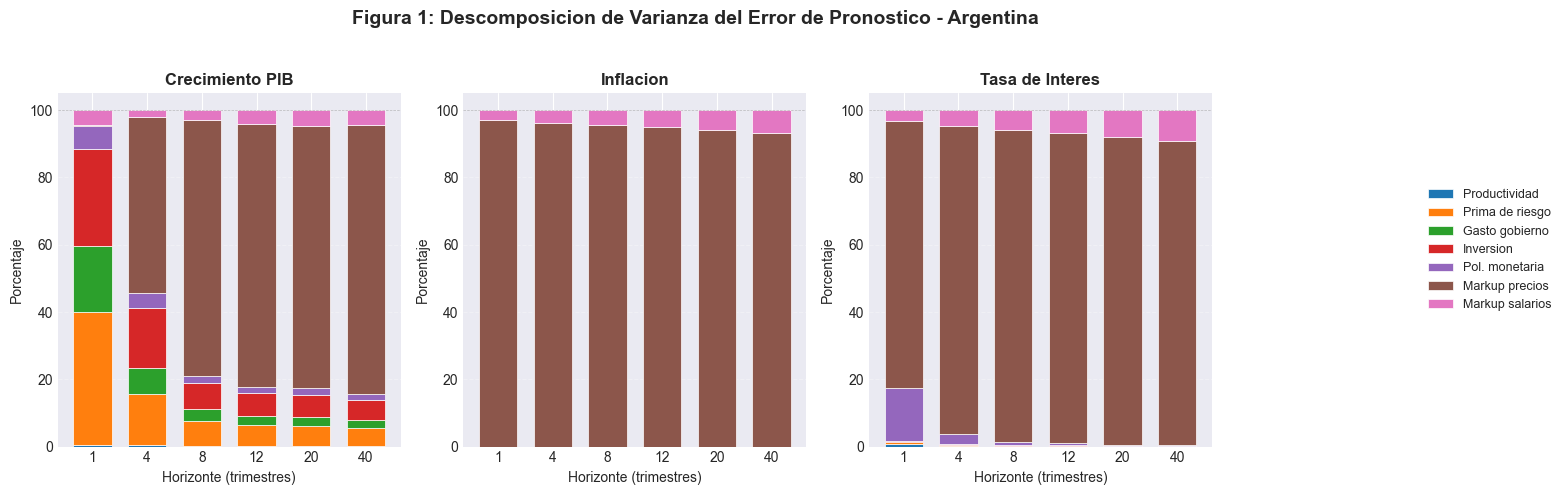


Figura 1 generada


In [8]:
def plot_figure1_fevd(fevd_df, variables, shock_order, shock_labels, var_labels):
    """Grafica Figura 1: FEVD como barras apiladas."""
    horizons_to_plot = [1, 4, 8, 12, 20, 40]
    horizon_labels = ['1', '4', '8', '12', '20', '40']
    
    fig, axes = plt.subplots(1, 3, figsize=(14, 5))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
    bar_width = 0.7
    
    for idx, var in enumerate(variables):
        ax = axes[idx]
        
        var_data = fevd_df[
            (fevd_df['variable'] == var) & 
            (fevd_df['horizon'].isin(horizons_to_plot))
        ].copy()
        
        if len(var_data) == 0:
            ax.set_title(f"{var_labels.get(var, var)} - NO DATA")
            continue
        
        x_positions = np.arange(len(horizons_to_plot))
        bottom = np.zeros(len(horizons_to_plot))
        
        for s_idx, shock in enumerate(shock_order):
            heights = []
            for h in horizons_to_plot:
                val = var_data[(var_data['horizon'] == h) & (var_data['shock'] == shock)]['variance_share']
                heights.append(val.values[0] if len(val) > 0 else 0)
            
            ax.bar(x_positions, heights, bar_width, bottom=bottom, 
                   label=shock_labels.get(shock, shock), color=colors[s_idx], 
                   edgecolor='white', linewidth=0.5)
            bottom += np.array(heights)
        
        ax.set_title(var_labels.get(var, var), fontsize=12, fontweight='bold')
        ax.set_xlabel('Horizonte (trimestres)', fontsize=10)
        ax.set_ylabel('Porcentaje', fontsize=10)
        ax.set_xticks(x_positions)
        ax.set_xticklabels(horizon_labels)
        ax.set_ylim(0, 105)
        ax.axhline(100, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.yaxis.grid(True, alpha=0.3, linestyle='--')
    
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5), fontsize=9)
    
    plt.suptitle('Figura 1: Descomposicion de Varianza del Error de Pronostico - Argentina', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 0.88, 0.95])
    
    return fig

print("Generando Figura 1: FEVD...\n")

fig1 = plot_figure1_fevd(
    fevd_df, 
    FIGURE1_VARIABLES, 
    SHOCK_ORDER, 
    SHOCK_LABELS, 
    FIGURE1_LABELS
)

plt.show()
print("\nFigura 1 generada")

## 7. Graficar Figura 2: IRFs

Generando Figura 2: IRFs...



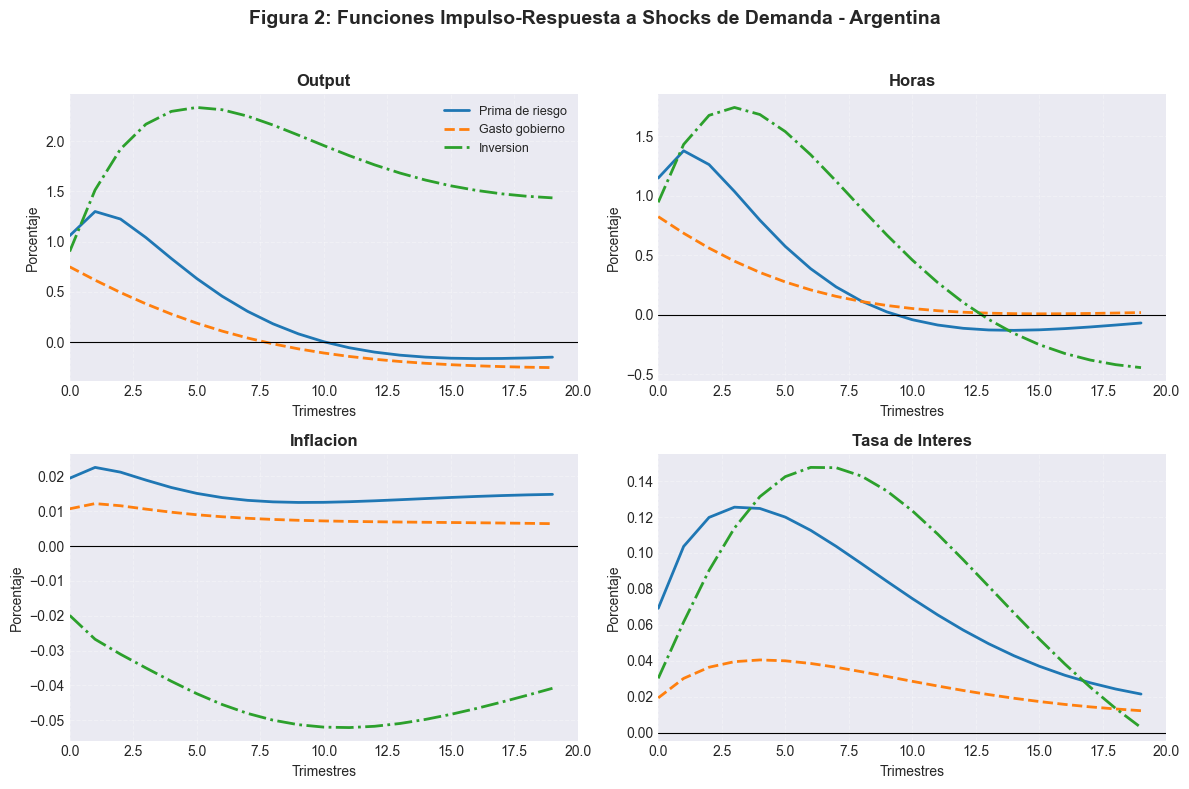


Figura 2 generada


In [9]:
def plot_figure2_irfs(irfs_df, variables, shocks, shock_labels, var_labels):
    """Grafica Figura 2: IRFs a shocks de demanda."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    shock_styles = {
        'eb': {'color': '#1f77b4', 'linestyle': '-', 'label': 'Prima de riesgo'},
        'eg': {'color': '#ff7f0e', 'linestyle': '--', 'label': 'Gasto gobierno'},
        'eqs': {'color': '#2ca02c', 'linestyle': '-.', 'label': 'Inversion'}
    }
    
    for idx, var in enumerate(variables):
        ax = axes[idx]
        
        for shock in shocks:
            irf_data = irfs_df[
                (irfs_df['variable'] == var) & 
                (irfs_df['shock'] == shock)
            ].sort_values('period')
            
            if len(irf_data) > 0:
                style = shock_styles.get(shock, {'color': 'gray', 'linestyle': '-'})
                ax.plot(irf_data['period'], irf_data['value'], 
                       color=style['color'], 
                       linestyle=style['linestyle'],
                       linewidth=2,
                       label=style.get('label', shock))
        
        ax.axhline(0, color='k', linestyle='-', linewidth=0.8)
        ax.set_title(var_labels.get(var, var), fontsize=12, fontweight='bold')
        ax.set_xlabel('Trimestres', fontsize=10)
        ax.set_ylabel('Porcentaje', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xlim(0, 20)
        
        if idx == 0:
            ax.legend(loc='upper right', fontsize=9)
    
    plt.suptitle('Figura 2: Funciones Impulso-Respuesta a Shocks de Demanda - Argentina', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

print("Generando Figura 2: IRFs...\n")

fig2 = plot_figure2_irfs(
    figure2_irfs,
    FIGURE2_VARIABLES,
    DEMAND_SHOCKS,
    SHOCK_LABELS,
    FIGURE2_LABELS
)

plt.show()
print("\nFigura 2 generada")

## 8. Exportar Resultados

In [10]:
# Crear directorios de salida
figures_dir = OUTPUT_PATH / 'figures'
tables_dir = OUTPUT_PATH / 'tables'
figures_dir.mkdir(parents=True, exist_ok=True)
tables_dir.mkdir(parents=True, exist_ok=True)

# Guardar figuras
fig1.savefig(figures_dir / 'figure1_fevd_argentina.png', dpi=300, bbox_inches='tight')
print(f"Figura 1 guardada en: {figures_dir / 'figure1_fevd_argentina.png'}")

fig2.savefig(figures_dir / 'figure2_irfs_argentina.png', dpi=300, bbox_inches='tight')
print(f"Figura 2 guardada en: {figures_dir / 'figure2_irfs_argentina.png'}")

# Guardar datos en CSV
fevd_figure1 = fevd_df[fevd_df['variable'].isin(FIGURE1_VARIABLES)]
fevd_figure1.to_csv(tables_dir / 'figure1_fevd_data_argentina.csv', index=False)
print(f"\nDatos FEVD guardados en: {tables_dir / 'figure1_fevd_data_argentina.csv'}")

figure2_irfs.to_csv(tables_dir / 'figure2_irfs_data_argentina.csv', index=False)
print(f"Datos IRFs guardados en: {tables_dir / 'figure2_irfs_data_argentina.csv'}")

Figura 1 guardada en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\DG\output\figures\figure1_fevd_argentina.png
Figura 2 guardada en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\DG\output\figures\figure2_irfs_argentina.png

Datos FEVD guardados en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\DG\output\tables\figure1_fevd_data_argentina.csv
Datos IRFs guardados en: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\DG\output\tables\figure2_irfs_data_argentina.csv


## 9. Resumen de Resultados

In [11]:
# Resumen FEVD
print("="*70)
print("RESUMEN: FEVD en horizontes seleccionados")
print("="*70)

for var in FIGURE1_VARIABLES:
    print(f"\n{FIGURE1_LABELS[var]}:")
    print("-" * 50)
    
    var_data = fevd_df[fevd_df['variable'] == var]
    
    for h in [1, 4, 10, 40]:
        h_data = var_data[var_data['horizon'] == h]
        print(f"  Horizonte {h:2d}:  ", end="")
        for shock in SHOCK_ORDER:
            share = h_data[h_data['shock'] == shock]['variance_share'].values
            if len(share) > 0:
                print(f"{shock}={share[0]:5.1f}%  ", end="")
        print()

RESUMEN: FEVD en horizontes seleccionados

Crecimiento PIB:
--------------------------------------------------
  Horizonte  1:  ea=  0.3%  eb= 39.6%  eg= 19.8%  eqs= 28.7%  em=  6.7%  epinf=  0.3%  ew=  4.6%  
  Horizonte  4:  ea=  0.4%  eb= 15.3%  eg=  7.6%  eqs= 17.8%  em=  4.6%  epinf= 52.1%  ew=  2.1%  
  Horizonte 10:  ea=  0.2%  eb=  6.5%  eg=  3.0%  eqs=  6.9%  em=  1.9%  epinf= 77.9%  ew=  3.6%  
  Horizonte 40:  ea=  0.2%  eb=  5.3%  eg=  2.5%  eqs=  5.7%  em=  1.8%  epinf= 80.0%  ew=  4.5%  

Inflacion:
--------------------------------------------------
  Horizonte  1:  ea=  0.0%  eb=  0.0%  eg=  0.0%  eqs=  0.0%  em=  0.0%  epinf= 97.0%  ew=  3.0%  
  Horizonte  4:  ea=  0.0%  eb=  0.0%  eg=  0.0%  eqs=  0.0%  em=  0.0%  epinf= 96.2%  ew=  3.8%  
  Horizonte 10:  ea=  0.0%  eb=  0.0%  eg=  0.0%  eqs=  0.0%  em=  0.0%  epinf= 95.2%  ew=  4.8%  
  Horizonte 40:  ea=  0.0%  eb=  0.0%  eg=  0.0%  eqs=  0.0%  em=  0.0%  epinf= 93.2%  ew=  6.8%  

Tasa de Interes:
----------------

In [12]:
# Resumen IRFs
print("\n" + "="*70)
print("RESUMEN: IRFs a shocks de demanda")
print("="*70)

for var in FIGURE2_VARIABLES:
    print(f"\n{FIGURE2_LABELS[var]}:")
    print("-" * 50)
    
    for shock in DEMAND_SHOCKS:
        irf_data = figure2_irfs[
            (figure2_irfs['variable'] == var) & 
            (figure2_irfs['shock'] == shock)
        ].sort_values('period')
        
        if len(irf_data) > 0:
            impact = irf_data[irf_data['period'] == 0]['value'].values[0]
            peak_idx = irf_data['value'].abs().idxmax()
            peak_period = irf_data.loc[peak_idx, 'period']
            peak_value = irf_data.loc[peak_idx, 'value']
            
            print(f"  {SHOCK_LABELS[shock]:15s}: Impacto={impact:+.4f}, Pico={peak_value:+.4f} (t={int(peak_period)})")


RESUMEN: IRFs a shocks de demanda

Output:
--------------------------------------------------
  Prima de riesgo: Impacto=+1.0589, Pico=+1.3000 (t=1)
  Gasto gobierno : Impacto=+0.7490, Pico=+0.7490 (t=0)
  Inversion      : Impacto=+0.9017, Pico=+2.3367 (t=5)

Horas:
--------------------------------------------------
  Prima de riesgo: Impacto=+1.1497, Pico=+1.3789 (t=1)
  Gasto gobierno : Impacto=+0.8253, Pico=+0.8253 (t=0)
  Inversion      : Impacto=+0.9456, Pico=+1.7431 (t=3)

Inflacion:
--------------------------------------------------
  Prima de riesgo: Impacto=+0.0195, Pico=+0.0226 (t=1)
  Gasto gobierno : Impacto=+0.0107, Pico=+0.0122 (t=1)
  Inversion      : Impacto=-0.0199, Pico=-0.0521 (t=11)

Tasa de Interes:
--------------------------------------------------
  Prima de riesgo: Impacto=+0.0692, Pico=+0.1255 (t=3)
  Gasto gobierno : Impacto=+0.0194, Pico=+0.0405 (t=4)
  Inversion      : Impacto=+0.0303, Pico=+0.1476 (t=6)


## 10. Cleanup

In [13]:
print("\n" + "="*70)
print("FIGURAS COMPLETADAS")
print("="*70)
print("\nFiguras generadas:")
print("  - figure1_fevd_argentina.png")
print("  - figure2_irfs_argentina.png")
print("\nDatos exportados:")
print("  - figure1_fevd_data_argentina.csv")
print("  - figure2_irfs_data_argentina.csv")

# Cerrar sesion Octave
di.close()
print("\nSesion Octave cerrada")


FIGURAS COMPLETADAS

Figuras generadas:
  - figure1_fevd_argentina.png
  - figure2_irfs_argentina.png

Datos exportados:
  - figure1_fevd_data_argentina.csv
  - figure2_irfs_data_argentina.csv

Sesion Octave cerrada
